In [1]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

In [2]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [3]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("AAPL")
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0
2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0


In [4]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_62640\410669001.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0
2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-24,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-25,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-26,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0


In [5]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,AAPL
Date,
2025-05-20,206.860001
2025-05-21,202.089996
2025-05-22,201.360001
2025-05-23,195.270004
2025-05-24,195.270004
2025-05-25,195.270004
2025-05-26,195.270004
2025-05-27,200.210007


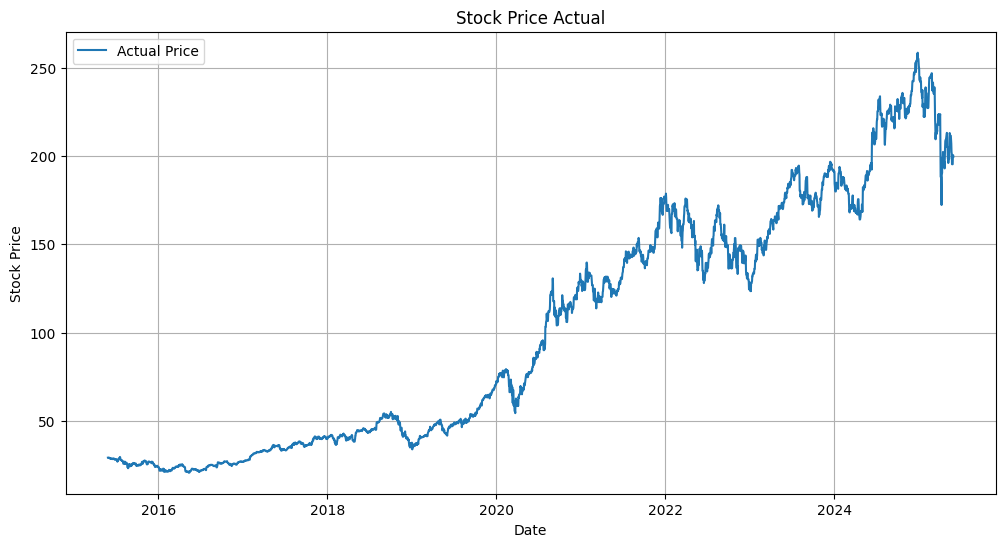

In [6]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
# Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [10]:
def improved_local_beam_search(
    beam_width=5, generations=10, max_no_improve=3,
    random_injection=2, min_diff=5, initial_temp=1.0, cooling_rate=0.95
):
    import random
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import MinMaxScaler

    # ---- Tạo cá thể ----
    def create_individual():
        return {
            'window_size': random.randint(30, 90),
            'units': random.choice([32, 64, 128])
        }

    # ---- Sinh hàng xóm ----
    def generate_neighbors(ind):
        neighbors = []
        for delta in [-5, 5]:
            new_ws = ind['window_size'] + delta
            if 30 <= new_ws <= 90:
                neighbors.append({'window_size': new_ws, 'units': ind['units']})
        for unit in [32, 64, 128]:
            if unit != ind['units']:
                neighbors.append({'window_size': ind['window_size'], 'units': unit})
        return neighbors

    # ---- Hàm tính fitness ----
    def fitness(ind):
        close_prices = data['Close'].values.reshape(-1, 1)
        train_size = int(len(close_prices) * 0.8)
        train_prices = close_prices[:train_size]
        val_prices = close_prices[train_size - ind['window_size']:]

        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_prices)
        val_scaled = scaler.transform(val_prices)

        X_train_gen, y_train_gen = create_dataset(train_scaled, ind['window_size'])
        X_val_gen, y_val_gen = create_dataset(val_scaled, ind['window_size'])

        model = build_model((ind['window_size'], 1), units=ind['units'])
        model.fit(X_train_gen, y_train_gen, epochs=3, batch_size=32, verbose=0)
        preds = model.predict(X_val_gen)
        return mean_squared_error(y_val_gen, preds)

    # ---- Diversity Check ----
    def is_diverse(candidate, selected, min_diff):
        for ind in selected:
            if abs(ind['window_size'] - candidate['window_size']) < min_diff and ind['units'] == candidate['units']:
                return False
        return True

    # ---- Stochastic Selection ----
    def stochastic_selection(candidates, scores, beam_width):
        scores = np.array(scores)
        scores = np.max(scores) - scores + 1e-6
        probs = scores / np.sum(scores)
        selected = []
        attempts = 0
        while len(selected) < beam_width and attempts < 100:
            i = np.random.choice(len(candidates), p=probs)
            if is_diverse(candidates[i], selected, min_diff):
                selected.append(candidates[i])
            attempts += 1
        return selected

    # ---- Memory (Tabu) ----
    evaluated = {}
    def serialize(ind):
        return f"{ind['window_size']}_{ind['units']}"

    # ---- Beam Search Core ----
    population = [create_individual() for _ in range(beam_width)]
    best_individual = None
    best_score = float('inf')
    no_improve = 0
    temp = initial_temp

    for gen in range(generations):
        print(f"\nGeneration {gen+1}")
        all_candidates = []

        # Tạo hàng xóm cho mỗi cá thể
        for ind in population:
            all_candidates.extend(generate_neighbors(ind))
        all_candidates.extend(population)

        # Thêm cá thể ngẫu nhiên (random injection)
        all_candidates.extend([create_individual() for _ in range(random_injection)])

        # Tính toán fitness nếu chưa được đánh giá
        scores = []
        for i, ind in enumerate(all_candidates):
            key = serialize(ind)
            if key not in evaluated:
                evaluated[key] = fitness(ind)
            scores.append(evaluated[key])
            print(f"Candidate {i+1}: window_size={ind['window_size']}, units={ind['units']}, MSE={evaluated[key]:.6f}")

        # Simulated annealing: chấp nhận cá thể kém hơn với xác suất nhỏ
        if best_individual:
            for ind, score in zip(all_candidates, scores):
                delta = score - best_score
                if delta < 0 or np.random.rand() < np.exp(-delta / (temp + 1e-6)):
                    if score < best_score:
                        best_score = score
                        best_individual = ind.copy()
                        no_improve = 0
                        print(f"New best (SA accepted): {ind}, MSE={score:.6f}")
                    break

        # Chọn beam mới bằng stochastic + diverse
        population = stochastic_selection(all_candidates, scores, beam_width)

        # Cập nhật best nếu có cá thể tốt hơn
        pop_scores = [evaluated[serialize(ind)] for ind in population]
        min_score = min(pop_scores)
        if min_score < best_score:
            best_score = min_score
            best_individual = population[pop_scores.index(min_score)].copy()
            print(f"New best: {best_individual}, MSE={best_score:.6f}")
            no_improve = 0
        else:
            no_improve += 1

        # Làm nguội nhiệt độ
        temp *= cooling_rate

        # Restart nếu không cải thiện
        if no_improve >= max_no_improve:
            print("Restarting due to stagnation...")
            population = [create_individual() for _ in range(beam_width)]
            no_improve = 0

    print(f"\nFinal best individual: window_size={best_individual['window_size']}, units={best_individual['units']}, MSE={best_score:.6f}")
    return best_individual


In [11]:
    # GA optimization
best_params = improved_local_beam_search()
print("Best Parameters from GA:", best_params)


Generation 1


InternalError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_62640\2788908189.py", line 2, in <module>
      best_params = improved_local_beam_search()
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_62640\4072633534.py", line 98, in improved_local_beam_search
      evaluated[key] = fitness(ind)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_62640\4072633534.py", line 44, in fitness
      model.fit(X_train_gen, y_train_gen, epochs=3, batch_size=32, verbose=0)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Tri_Tue_Nhan_Tao\Project_AI\stock-market-price-prediction-1\.conda\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense/MatMul'
Blas xGEMV launch failed : a.shape=[1,32,128], b.shape=[1,128,1], m=32, n=1, k=128
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_train_function_5469]

In [ ]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
X_train, y_train = create_dataset(scaled_train, best_params['window_size'])
X_val, y_val = create_dataset(scaled_val, best_params['window_size'])
X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)

In [ ]:
# Dự đoán từng phần
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Inverse transform các phần
y_train_rescaled = scaler.inverse_transform(y_train)
train_preds_rescaled = scaler.inverse_transform(train_preds)

y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

y_test_rescaled = scaler.inverse_transform(y_test)
test_preds_rescaled = scaler.inverse_transform(test_preds)

# Lấy index ngày tương ứng
train_start = best_params['window_size']
val_start = train_end
test_start = val_end

train_dates = data.index[train_start:train_start + len(y_train)]
val_dates = data.index[val_start:val_start + len(y_val)]
test_dates = data.index[test_start:test_start + len(y_test)]

# Vẽ biểu đồ chung
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_rescaled, label='Actual Train', color='blue')
#plt.plot(train_dates, train_preds_rescaled, label='Predicted Train', color='black', linestyle='--')

plt.plot(val_dates, y_val_rescaled, label='Actual Val', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Val', color='purple', linestyle='--')

plt.plot(test_dates, y_test_rescaled, label='Actual Test', color='green')
plt.plot(test_dates, test_preds_rescaled, label='Predicted Test', color='red', linestyle='--')

plt.title('Stock Price Prediction vs Actual (Train, Val, Test)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)

# Inverse transform y_val và dự đoán
y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

# MAE trên tập validation
val_mae = np.mean(np.abs(y_val_rescaled - val_preds_rescaled))
print("Độ sai số trung bình trên tập validation:", val_mae, "dolar")

# Lấy index ngày đúng cho tập validation
val_start_index = train_end + best_params['window_size']
val_dates = data.index[val_start_index : val_start_index + len(y_val)]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_rescaled, label='Actual Price', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Price', color='purple', linestyle='--')
plt.title('PSO Validation Set: Predicted vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
mae = np.mean(np.abs(y_test_rescaled- preds_rescaled))
print("Độ sai số trung bình trên tập test:", mae, "dolar")
mape = np.mean(np.abs((y_test_rescaled - preds_rescaled) / y_test_rescaled)) * 100 # Tỷ lệ phần trăm sai số trung bình
print(f"MAPE trên tập test: {mape:.2f}%")
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('PSO Test: Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Chỉ lấy 100 mẫu cuối cùng
num_plot = 100
y_test_subset = y_test[-num_plot:]
preds_subset = preds[-num_plot:]

# Biến đổi ngược lại giá gốc
y_test_rescaled = scaler.inverse_transform(y_test_subset)
preds_rescaled = scaler.inverse_transform(preds_subset)

# Lấy đúng 100 ngày cuối tương ứng trong dữ liệu gốc
dates = data.index[-num_plot:]

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('PSO Test: Stock Price Prediction vs Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
